# 02: Production
## Setup
Import fastbook and patch IPython for VS Code

In [1]:
from fastbook import *
from fastai.vision.widgets import *
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

Set up a path to store the images

In [2]:
data_path = Path('data')/'02'
data_path.mkdir(parents=True,exist_ok=True)

## Download Images

In [3]:
results = search_images_ddg('grizzly bear')
ims=results[:200]
len(ims)

200

In [4]:
dest = data_path/'grizzly.jpg'
download_url(ims[0], dest)

Path('data/02/grizzly.jpg')

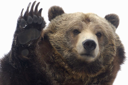

In [5]:
im = Image.open(dest)
im.to_thumb(128, 128)

In [6]:
bear_types = 'grizzly','black','teddy'
path = data_path/'bears'

In [7]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear')
        download_images(dest, urls=results[:200])

In [8]:
fns = get_image_files(path)

In [9]:
failed = verify_images(fns)
failed.map(Path.unlink)

(#0) []

In [10]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
)

In [23]:
dls = bears.dataloaders(path)

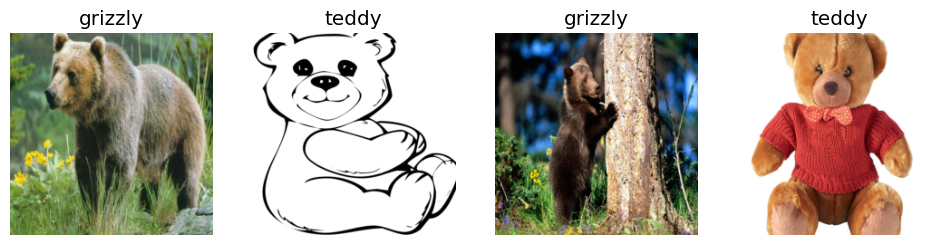

In [24]:
dls.valid.show_batch(max_n=4, nrows=1)

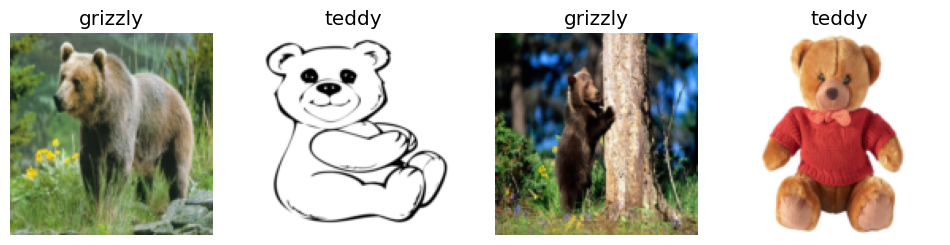

In [25]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

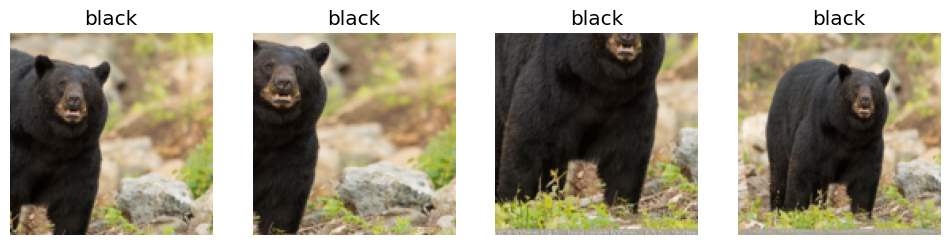

In [26]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

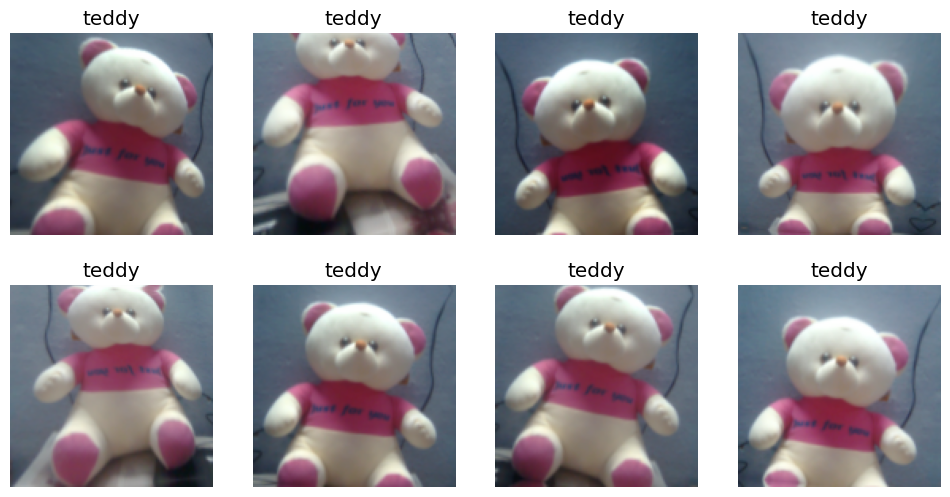

In [15]:
bear = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [16]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = bears.dataloaders(path)

In [27]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.387830,0.063339,0.027778,00:02
1,0.318884,0.043817,0.018519,00:03
2,0.276268,0.042250,0.018519,00:02
3,0.237925,0.047473,0.018519,00:03


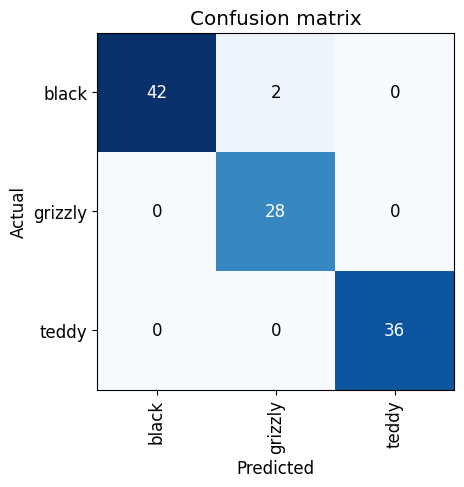

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

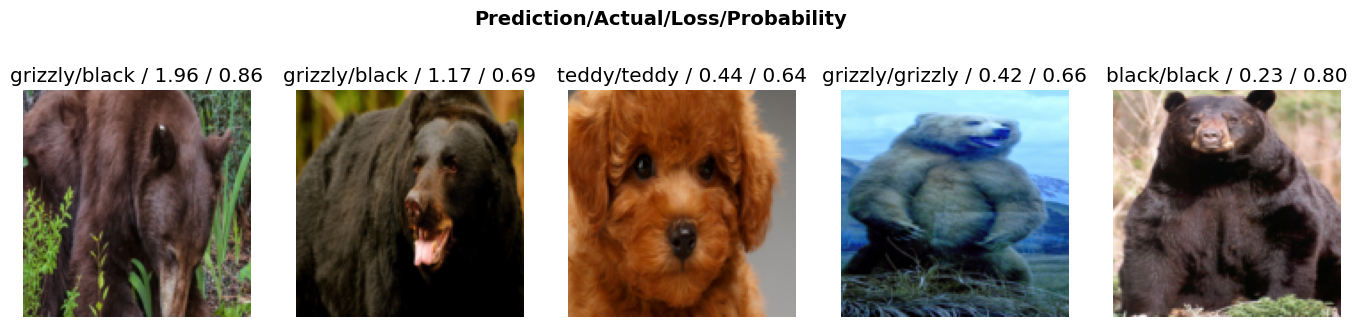

In [29]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

In [30]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [21]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
learn.export("model.pkl")